#### Notes to myself
+ Maybe the proof section is not so useful after all
+ I need to find references / proofs about existence of solutions to the problem (esp in bayes section) and better define assumptions and requirements about the involved components
+ add convergence proofs / estimation and compare with numerical results
+ replace static with adaptive bridging (= tempering?) 

In [1]:
include("includes.jl");

# Monte Carlo methods for Bayesian Inversion

The estimation of parameters in mathematical models from observational data has led to the development of many different mathematical and computational advances. The Bayesian approach to the inversion problem allows us to take incorporate different kind of uncertainties in the estimation of these parameters, thus enlarging the space of well-posed problems to be solved. 

In this notebook, we present a simple and illustrative inversion problem arising from estimating the parameter of a differential equation from noisy measurements of an experiment. This example will help us analyse and compare different numerical solutions to the Bayesian formulation of its inversion problem.

### The experiment

The experiment presented in this notebook was designed for the estimation of the Earth's gravitational constant $g$, using measurements of the movement of a pendulum. The movement of the pendulum is described by an ordinary differential equation modeling the evolution of the pendulum's angular acceleration depending on $g$.

$$
    \frac{d^2\theta_g}{dt^2} + \frac{g}{l} \sin \theta_g = 0
$$

In which $l$ is a known parameter representing the length of the pendelum and $g$ is the parameter we would like to estimate.

The data used for making an estimation of the parameter $g$ was obtained by letting children run an experiment with the pendulum, in which they were asked, after letting the pendulum free from a $5^{\circ}$ angle at time $t_0 = 0$, to measure times $(t_1, ..., t_n)$ at which the pendulum met a zero angle, thus giving $\theta\left(t_i\right) = 0$.

### Bayesian inverse problem

In a more general setting, we are trying to find an estimate of the real parameter $\theta^\star \in X \subset \mathbb{R}^n$ of a model $\mathcal{G} : X \rightarrow Y$ with $Y \subset \mathbb{R}^m$ and $m \in \mathbb{N}$ from observations $y \in Y$.

To model the uncertainties present in the observations due to different factors such as measurements or model error, we treat $y$ as the realization of a mean zero Gaussian error term $\eta \sim \mathcal{N}\left(0, \Gamma\right)$ added to the model giving

$$
    y = \mathcal{G}\left(\theta^\star\right) + \eta
$$

the problem of inverting the function $\mathcal{G} + \eta$ to reconstruct $\theta^\star$ is ill-defined, such that in general, there is no $\theta \in X$ satisfying $\mathcal{G}\left(\theta\right) = y$. This leads us to reformulate our problem in which we do not try anymore to find $\theta^\star$ but rather try to estimate a probasbility measure for the parameter $\theta$ given the realization vector $y$.

This is done by assuming $\theta \sim \mu_0$ where $\mu_0$ is a probability measure called the _prior measure_, which encodes existing knowledge about the distribution of the searched parameter. How to define $\mu_0$ is out of the scope of this work, but much effort can be put in designing $\mu_0$ in order to constraint, define and refine the explorable parameter space, interested readers are invited to refer to [...]. By further assuming independence of $\theta$ and $\eta$, we can define the _posterior measure_ $\mu^y$, solution of the Bayesian inverse problem  

$$
    \mu^y := \mathbb{P}\left(\theta \in \cdot \mid \mathcal{G}\left(\theta\right) + \eta = y\right)
$$

The goal of this work will be to explore ways to explore the posterior distribution and $\frac{\text{d}\mu^y}{\text{d}\mu_0}$, its density function with respect to $\mu_0$. Because $\mu^y$ usually doesn't have an analytical solution, we now focus on refining its structure in hope of being able to better understand how to numerically estimate it.


For this, we start by defining a _likelihood function_

$$
\Phi(\theta; y) := \frac{1}{2}\lVert \Gamma^{-\frac{1}{2}}(y - \mathcal{G}(\theta))\rVert^2_2 
$$

By Bayes' theorem, it then follows (proof bellow) that $\frac{\text{d}\mu^y}{\text{d}\mu_0}(\theta) \propto \exp(-\Phi(\theta; y))$ up to a _normalizing constant_

$$
Z_y := \int_X \exp(-\Phi(\theta))\ \text{d}\mu_0(\theta)
$$




### Problem modeling, a first attempt

The first attempt to model our problem in the Bayesian framework will be the following.

We first denote $\theta_g$ as the discretized solution of the differential equation stated above and given the recorded tuples of experiment measurements $( (t_1^i, \ldots, t_n^i)\ \text{for}\ i = 1 \ldots m )$, we flatten the vector of time measurements as $T = ( t_i^j\
\text{for}\ i = 1 \ldots n,\ j = 1 \ldots m )$ and define the forward response operator $\mathcal{G} : \mathbb{R}_{\gt 0} \rightarrow \mathbb{R}$ as

$$
    \mathcal{G}(g) = ( \theta_g(T_1), \ldots, \theta_g(T_{nm} ))
$$



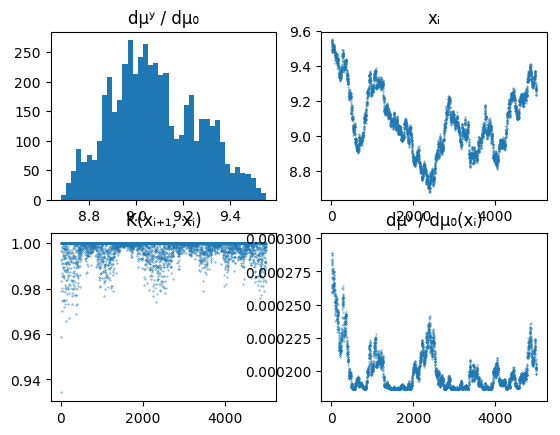

4985 / 5000 of the sampled particles were accepted (100.0%)
        
The mean estimation is of 9.08267240382711


In [9]:
flat_measurements = [0; load_flat_data()]

μ₀ = Uniform(5,15)

likelihood = g ->
    let
        dΘ = Θ -> [Θ[2], -g*sin(Θ[1])/7.4]
        B = rk4s(dΘ, [5*pi/180, 0], flat_measurements, 0.01)
        exp( - sumoveri(i -> B[i,1]^2, length(t)))
    end

unnormalized_posterior = m ->
    let
        p = pdf(μ₀, m[1])
        p > 0 ? p*likelihood(m[1]) : 0
    end;

### Computing an estimate: Metropolis-Hastings

In [ ]:
srand(42)
out = MetropolisHastings(5000, unnormalized_posterior, 0.01, g₀)
plotMCMC(out)

### A better model

In [10]:
@everywhere function simulate(n, g; Θ₀ = 5*pi/180, l = 7.4, τ = 0.01)
    n_times = 0
    times = zeros(n)

    t = 0
    Θ = [Θ₀, 0]
    
    function dΘ(Θ)
        [Θ[2], -g*sin(Θ[1])/l]
    end
    
    while n_times < n
        Θₙ = rk4(dΘ, Θ, τ)
        
        # if the angle has changed sign, we linearly approximate the intersection
        # with 0
        if Θ[1] * Θₙ[1] <= 0
            t_intersect = t - τ*Θ[1]/(Θₙ[1] - Θ[1])
            n_times += 1
            times[n_times] = t_intersect
        end
        
        Θ = Θₙ
        t += τ
    end
    
    times
end

In [ ]:
measurements, measurements_mask = load_experiments()
n_measurements = size(measurements)[1]
max_intersects = size(measurements)[2]

μ₀ = Uniform(5,15)

likelihood = m ->
    let
        t = simulate(max_intersects, m[1])
        exp(-sumoveri(i -> sum(measurements_mask[i,:] .* (measurements[i,:] - t).^2), n_measurements))
    end

unnormalized_posterior = m ->
    let
        p = pdf(μ₀, m[1])
        p > 0 ? p*likelihood(m) : 0
    end;

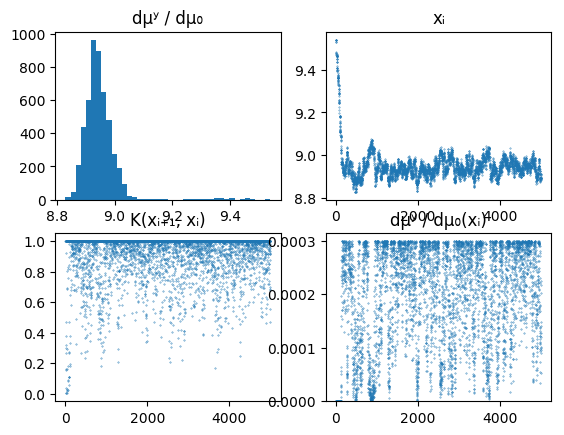

4563 / 5000 of the sampled particles were accepted (91.0%)
        
The mean estimation is of 8.950853868774033


In [7]:
srand(42);

g₀ = let
    G = rand(μ₀, 10)
    G[findmax(likelihood.(G))[2]]
end

out = MetropolisHastings(5000, unnormalized_posterior, 0.01, g₀)
plotMCMC(out)

### Sequential Monte Carlo

In [37]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere n_measurements = size(measurements)[1]
@everywhere max_intersects = size(measurements)[2]

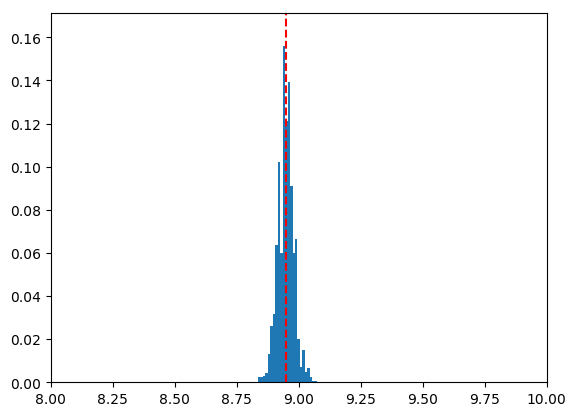

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa1fa2ac390>

In [42]:
@everywhere likelihood₁ = (n, m) ->
    let
        t = simulate(max_intersects, m[1])
        exp(-sumoveri(i -> sum(measurements_mask[i,:] .* (measurements[i,:] - t).^2), n))
    end

@everywhere srand(42)
out = SequentialMonteCarlo(rand(μ₀,100,1), n_measurements, likelihood₁);

plotSMC(out)

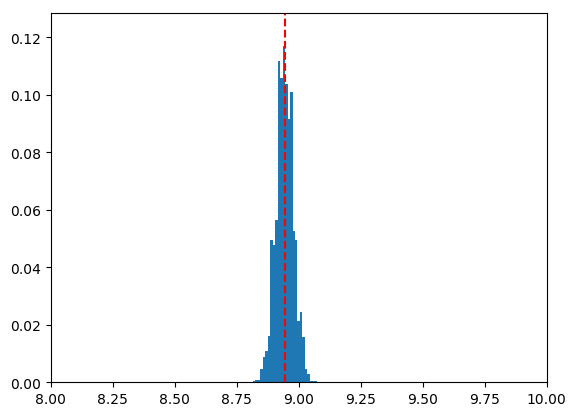

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa1fa10fdd0>

In [43]:
@everywhere ϕs = linspace(0, 1, 20)
@everywhere likelihood₂ = (n, m) ->
    let
        t = simulate(max_intersects, m[1])
        l = exp(-sumoveri(i -> sum(measurements_mask[i,:] .* (measurements[i,:] - t).^2), n_measurements))
    
        l^ϕs[n]
    end

@everywhere srand(42)
out = SequentialMonteCarlo(rand(μ₀,500,1), length(ϕs), likelihood₂);
plotSMC(out)

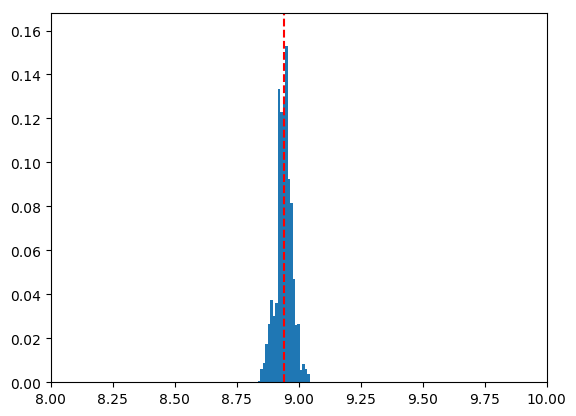

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa1f905ea10>

In [53]:
@everywhere is = [(i,j) for i=1:n_measurements for j=linspace(0, 1, 5)]
@everywhere likelihood₃ = (n, m) ->
    let
        (j, ϕ) = is[n]
        t = simulate(max_intersects, m[1])
        
        if j == 1
            return exp(-sum(measurements_mask[1,:] .* (measurements[1,:] - t).^2))^ϕ
        end
        
        l = exp(-sumoveri(i -> sum(measurements_mask[i,:] .* (measurements[i,:] - t).^2), j-1))
        lⱼ = l * exp(-sum(measurements_mask[j,:] .* (measurements[j,:] - t).^2))

        l^(1-ϕ)*lⱼ^ϕ
    end

@everywhere srand(42)
out = SequentialMonteCarlo(rand(μ₀,100,1), length(is), likelihood₃);
plotSMC(out)

#### Proof of $\frac{\text{d}\mu^y}{\text{d}\mu_0} \propto \exp(-\Phi(\cdot; y))$

We start by recognizing from the distribution of $\eta$ that $\mathbb{P}\left(\mathcal{G}\left(\theta\right) + \eta = y\right) \propto \exp(-\Phi(\theta; y))$

$$
\begin{split}
\mu^y(A) 
&= \mathbb{P}\left(\theta \in A \mid \mathcal{G}\left(\theta\right) + \eta = y\right) \\
&= \frac{\mathbb{P}\left(\theta \in A, \mathcal{G}\left(\theta\right) + \eta = y\right)}{\mathbb{P}\left(\mathcal{G}\left(\theta\right) + \eta = y\right)} \\
&= \frac{\mathbb{P}\left(\mathcal{G}\left(\theta\right) + \eta = y \mid \theta \in A\right)\mathbb{P}\left(\theta \in A \right)}{\mathbb{P}\left(\mathcal{G}\left(\theta\right) + \eta = y\right)} \\
&= \frac{ \int_A \mathbb{P}\left(\mathcal{G}\left(\theta\right) + \eta = y\right)\ \text{d}\mu_0(\theta)}{\int_X \mathbb{P}\left(\mathcal{G}\left(\theta\right) + \eta = y\right)\ \text{d}\mu_0(\theta)}  \\
&= \frac{ \int_A \exp(-\Phi(\theta; y))\ \text{d}\mu_0(\theta)}{\int_X \exp(-\Phi(\theta; y))\ \text{d}\mu_0(\theta)} \\
&= \int_A \frac{1}{Z_y}\exp(-\Phi(\theta; y))\ \text{d}\mu_0(\theta)
\end{split}
$$

As $\mu^y \ll \mu_0$ (why?) it follows from the Radon-Nikodym theorem that

$$
  \frac{\text{d}\mu^y}{\text{d}\mu_0} = \frac{1}{Z_y}\exp(-\Phi(\cdot; y))
$$